In [1]:
import os
import cv2
import pandas as pd
import numpy as np
from IPython.display import display, HTML, clear_output
from ipywidgets import FloatProgress
import matplotlib.pyplot as plt
%matplotlib inline
from pathlib import Path
import hashlib
from PIL import Image
import fastparquet as fp

In [2]:
PROJECT_ROOT = Path('tobacco_grading')
PATHS = {
    'raw': PROJECT_ROOT/'data/raw',# Raw image storage
    'processed': PROJECT_ROOT/'data/processed/images', # Processed images
    'metadata': PROJECT_ROOT/'data/processed/metadata.csv', # Metadata file
    'features': PROJECT_ROOT/'data/processed/full_features.parquet', # Feature storage
    'model': PROJECT_ROOT/'model' # Model storage
}

for path in PATHS.values():
    if path.suffix not in {'.csv', '.parquet'}:
        path.mkdir(parents=True, exist_ok=True)

In [3]:
def show_status(message, status_type='info'):
    # Color configuration with improved contrast
    status_config = {
        'info': {
            'color': '#004085',
            'bg_color': 'rgba(0, 64, 133, 0.1)',
            'icon': 'ℹ️'
        },
        'success': {
            'color': '#155724',
            'bg_color': 'rgba(40, 167, 69, 0.1)',
            'icon': '✅'
        },
        'warning': {
            'color': '#856404',
            'bg_color': 'rgba(255, 193, 7, 0.1)',
            'icon': '⚠️'
        },
        'error': {
            'color': '#721c24',
            'bg_color': 'rgba(220, 53, 69, 0.1)',
            'icon': '❌'
        }
    }
    
    # Fallback to info for unknown types
    config = status_config.get(status_type.lower(), status_config['info'])
    
    # Sanitize message text
    safe_message = HTML(message).data.replace('\n', '<br>')
    
    # Create HTML template
    html = f"""
    <div style="
        padding: 12px;
        margin: 10px 0;
        border-left: 4px solid {config['color']};
        background-color: {config['bg_color']};
        border-radius: 4px;
        font-family: system-ui, sans-serif;
        animation: fadeIn 0.5s;
    ">
        <div style="
            display: flex;
            align-items: center;
            gap: 8px;
        ">
            <span style="font-size: 1.2em">{config['icon']}</span>
            <strong style="color: {config['color']};">{status_type.upper()}:</strong>
            <span style="color: {config['color']};">{safe_message}</span>
        </div>
    </div>
    
    <style>
        @keyframes fadeIn {{
            from {{ opacity: 0; transform: translateY(-10px); }}
            to {{ opacity: 1; transform: translateY(0); }}
        }}
    </style>
    """
    
    display(HTML(html))

In [4]:
def process_images():
    clear_output(wait=True)
    try:
        # Phase 1: Image discovery
        raw_path = Path(PATHS['raw'])
        if not raw_path.exists():
            show_status('Raw data directory not found', 'error')
            return

        supported_formats = ('.png', '.jpg', '.jpeg', '.webp')
        image_paths = [
            p for p in raw_path.rglob('*')
            if p.suffix.lower() in supported_formats and p.is_file()
        ]

        if not image_paths:
            show_status('No valid images found', 'error')
            return

        # Initialize progress tracking
        progress = FloatProgress(min=0, max=len(image_paths)+5, description='Processing:')
        display(progress)
        
        # Initialize empty processed_paths list
        processed_paths = []
        failure_count = 0

        # Phase 2: Image processing
        progress.description = 'Processing images...'
        processing_params = {
            'target_size': (512, 512),
            'filter_params': (9, 75, 75),
            'quality': 95
        }

        for path in image_paths:
            try:
                # Read and validate image
                img = cv2.imread(str(path), cv2.IMREAD_UNCHANGED)
                if img is None or img.size == 0:
                    raise ValueError("Invalid or corrupted image file")

                # Processing pipeline
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = cv2.resize(img, processing_params['target_size'], interpolation=cv2.INTER_AREA)
                img = cv2.bilateralFilter(img, *processing_params['filter_params'])
                
                # Adaptive histogram equalization
                lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
                lab[...,0] = cv2.createCLAHE(clipLimit=3.0).apply(lab[...,0])
                img = cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)

                # Save processed image
                rel_path = path.relative_to(raw_path)
                dest_path = Path(PATHS['processed']) / rel_path
                dest_path.parent.mkdir(parents=True, exist_ok=True)
                
                cv2.imwrite(str(dest_path), cv2.cvtColor(img, cv2.COLOR_RGB2BGR), 
                           [int(cv2.IMWRITE_JPEG_QUALITY), processing_params['quality']])
                processed_paths.append(str(dest_path))
                
            except Exception as e:
                failure_count += 1
                show_status(f"Skipped {path.name}: {str(e)}", 'warning')
                processed_paths.append(None)
            
            progress.value += 1

        # Phase 3: Metadata creation
        progress.description = 'Creating metadata...'
        metadata = pd.DataFrame({
            'original_path': [str(p) for p in image_paths],
            'processed_path': processed_paths,
            'label': [p.parent.name for p in image_paths],  # Simplified path handling
            'original_size': [p.stat().st_size for p in image_paths]
        })

        # Phase 4: Metadata updates
        progress.description = 'Updating metadata...'
        metadata['processing_success'] = metadata['processed_path'].notnull()
        metadata = metadata.dropna(subset=['processed_path']).reset_index(drop=True)
        
        metadata['processed_size'] = metadata['processed_path'].apply(
            lambda p: Path(p).stat().st_size if p else 0
        )
        progress.value += 1

        # Phase 5: Saving results
        progress.description = 'Saving results...'
        metadata.to_csv(PATHS['metadata'], index=False)
        
        metadata['checksum'] = metadata['processed_path'].apply(
            lambda p: hashlib.md5(Path(p).read_bytes()).hexdigest() if p else ''
        )
        progress.value += 1

        # Final output
        clear_output()
        success_rate = len(metadata)/len(image_paths) * 100
        summary = f"""
        Processed {len(metadata)}/{len(image_paths)} images successfully ({success_rate:.1f}%)
        - Input size: {sum(metadata['original_size'])/1e6:.2f} MB
        - Output size: {sum(metadata['processed_size'])/1e6:.2f} MB
        - Compression ratio: {sum(metadata['processed_size'])/sum(metadata['original_size']):.2f}
        """
        show_status(summary, 'success')

        # Visualization
        display(HTML("<h3 style='color: #2c3e50;'>Processing Report</h3>"))
        
        # Quality comparison grid
        fig, axes = plt.subplots(2, 3, figsize=(15, 10))
        samples = metadata.sample(3, random_state=42)
        
        for idx, (_, row) in enumerate(samples.iterrows()):
            axes[0, idx].imshow(Image.open(row['original_path']))
            axes[0, idx].set_title(f"Original\n{Path(row['original_path']).name}", fontsize=10)
            axes[1, idx].imshow(Image.open(row['processed_path']))
            axes[1, idx].set_title(f"Processed\n{row['processed_size']/1e3:.1f} KB", fontsize=10)
            for ax in axes[:, idx]:
                ax.axis('off')
        
        plt.tight_layout()
        plt.show()

        # Size distribution plot
        plt.figure(figsize=(10, 5))
        plt.hist(metadata['original_size']/1e3, alpha=0.5, label='Original')
        plt.hist(metadata['processed_size']/1e3, alpha=0.5, label='Processed')
        plt.xlabel('File Size (KB)')
        plt.ylabel('Count')
        plt.title('Size Distribution Comparison')
        plt.legend()
        plt.show()

    except Exception as e:
        show_status(f'Critical processing failure: {str(e)}', 'error')
        raise

In [5]:
import numpy as np
import cv2
import joblib
from pathlib import Path
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import preprocess_input
from tqdm import tqdm

In [6]:
class FeatureExtractor:
    def __init__(self, layer_names=None):
        """
        Initialize feature extractor with configurable layer outputs
        :param layer_names: List of layer names to extract features from
        """
        self.base_model = ResNet50(weights='imagenet', include_top=False)
        self.layer_names = layer_names or [
            'conv1_relu',
            'conv2_block3_out',
            'conv3_block4_out',
            'conv4_block6_out',
            'conv5_block3_out'
        ]
        self.feature_models = self._create_feature_models()
        self.scaler = MinMaxScaler()
        self.is_scaler_fitted = False

    def _create_feature_models(self):
        """Create multi-output feature extraction model"""
        outputs = [self.base_model.get_layer(name).output 
                  for name in self.layer_names]
        return Model(inputs=self.base_model.input, outputs=outputs)

    def _process_layer_output(self, features):
        """Extract spatial features from layer outputs using numpy"""
        processed = []
        for layer_feat in features:
            # Global average pooling
            gap = np.mean(layer_feat, axis=(1, 2))
            # Global max pooling
            gmp = np.max(layer_feat, axis=(1, 2))
            # Standard deviation
            std = np.std(layer_feat, axis=(1, 2))
            # Combined features
            processed.append(np.concatenate([gap, gmp, std], axis=1))
        return np.concatenate(processed, axis=1)

    def _load_and_preprocess(self, path):
        """Robust image loading with proper preprocessing"""
        try:
            img = cv2.imread(str(path))
            if img is None:
                raise ValueError("Empty image file")
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (224, 224))
            return preprocess_input(img)
        except Exception as e:
            print(f"Error processing {path.name}: {str(e)}")
            return None

    def process(self, image_paths, batch_size=32, fit_scaler=False):
        """
        Process images and extract features
        :param image_paths: List of paths to process
        :param batch_size: Batch size for processing
        :param fit_scaler: Whether to fit new scaler or use existing
        """
        valid_paths = []
        all_features = []
        
        # Convert to Path objects
        image_paths = [Path(p) for p in image_paths]

        with tqdm(total=len(image_paths), desc="Processing images") as pbar:
            for i in range(0, len(image_paths), batch_size):
                batch_paths = image_paths[i:i+batch_size]
                batch_images = []
                
                for path in batch_paths:
                    img = self._load_and_preprocess(path)
                    if img is not None:
                        batch_images.append(img)
                        valid_paths.append(path)
                
                if batch_images:
                    # Single forward pass for all layers
                    layer_outputs = self.feature_models.predict(np.array(batch_images))
                    batch_features = self._process_layer_output(layer_outputs)
                    all_features.append(batch_features)
                
                pbar.update(len(batch_paths))

        if not all_features:
            return np.array([]), []
            
        combined_features = np.vstack(all_features)
        
        # Scaler handling
        if fit_scaler or not self.is_scaler_fitted:
            self.scaler.fit(combined_features)
            self.is_scaler_fitted = True
            
        return self.scaler.transform(combined_features), valid_paths

    def save_scaler(self, path):
        """Save fitted scaler to disk"""
        joblib.dump(self.scaler, path)

    def load_scaler(self, path):
        """Load pre-trained scaler"""
        self.scaler = joblib.load(path)
        self.is_scaler_fitted = True

In [7]:
def run_feature_extraction():
    clear_output(wait=True)
    progress = FloatProgress(min=0, max=4, description='Extracting:', bar_style='info')
    display(progress)

    try:
        # Phase 1: Load and validate metadata
        progress.value += 1
        metadata = pd.read_csv(PATHS['metadata'])
        metadata['processed_path'] = metadata['processed_path'].apply(Path)
        valid_images = metadata[metadata['processed_path'].apply(lambda p: p.exists())]

        # Phase 2: Initialize feature extractor
        progress.value += 1
        extractor = FeatureExtractor()

        # Phase 3: Extract features
        progress.value += 1
        features, valid_paths = extractor.process(
            valid_images['processed_path'].tolist(),
            fit_scaler=True
        )

        # Phase 4: Create final dataframe
        valid_paths_str = [str(p) for p in valid_paths]
        final_df = valid_images[valid_images['processed_path'].isin(valid_paths)].copy()
        
        final_df = final_df.astype({
            'processed_path': 'string',
            'label': 'category'
        })

        feature_cols = [f'feat_{i}' for i in range(features.shape[1])]
        final_df[feature_cols] = features

        # Phase 5: Save results
        progress.value += 1
        Path(PATHS['model']).mkdir(parents=True, exist_ok=True)
        
        # Using fastparquet instead of pyarrow
        final_df.to_parquet(
            PATHS['features'],
            engine='fastparquet',  # Changed engine
            compression='snappy'
        )
        
        extractor.save_scaler(Path(PATHS['model']) / 'feature_scaler.pkl')

        # Display results
        clear_output()
        success_msg = f'''
        Extracted {features.shape[1]} features from {len(final_df)} images
        - Average feature magnitude: {np.mean(features):.2f}
        - Feature range: [{np.min(features):.2f}, {np.max(features):.2f}]
        '''
        show_status(success_msg, 'success')
        
        display(HTML("<h4 style='color: #2c3e50;'>Feature Summary</h4>"))
        display(final_df[['label'] + feature_cols[:5]].describe())

    except Exception as e:
        show_status(f'Feature extraction failed: {str(e)}', 'error')
        raise

In [8]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, GridSearchCV

In [9]:
def train_and_evaluate():
    clear_output(wait=True)
    progress = FloatProgress(min=0, max=6, description='Training:', bar_style='info')
    display(progress)

    try:
        # Phase 1: Data Loading and Validation
        progress.value += 1
        df = pd.read_parquet(PATHS['features'])
        if df.empty or 'label' not in df.columns:
            raise ValueError("Invalid feature data or missing labels")
            
        X = df.filter(like='feat_').values
        y = df['label'].values
        classes = np.unique(y)

        # Phase 2: Stratified Data Splitting
        progress.value += 1
        X_train, X_temp, y_train, y_temp = train_test_split(
            X, y, 
            test_size=0.3, 
            stratify=y, 
            random_state=42
        )
        X_val, X_test, y_val, y_test = train_test_split(
            X_temp, y_temp, 
            test_size=0.67,  # 20% of original
            stratify=y_temp, 
            random_state=42
        )

        # Phase 3: Hyperparameter Tuning
        progress.value += 1
        param_grid = {
            'n_neighbors': [3, 5, 7, 9],
            'weights': ['uniform', 'distance'],
            'metric': ['cosine', 'minkowski']
        }
        
        grid_search = GridSearchCV(
            KNeighborsClassifier(n_jobs=-1),
            param_grid,
            cv=5,
            scoring='balanced_accuracy',
            verbose=0
        )
        grid_search.fit(X_train, y_train)
        best_knn = grid_search.best_estimator_

        # Phase 4: Final Evaluation
        progress.value += 1
        sets = {
            'Train': (X_train, y_train),
            'Validation': (X_val, y_val),
            'Test': (X_test, y_test)
        }
        
        reports = {}
        for name, (X_set, y_set) in sets.items():
            y_pred = best_knn.predict(X_set)
            reports[name] = classification_report(y_set, y_pred, output_dict=True)

        # Phase 5: Model Saving
        progress.value += 1
        model_path = Path(PATHS['model']) / 'knn_model.pkl'
        joblib.dump({
            'model': best_knn,
            'classes': classes,
            'params': grid_search.best_params_,
            'scorer': grid_search.scorer_
        }, model_path)

        # Phase 6: Enhanced Reporting
        progress.value += 1
        clear_output()
        show_status(f'''
        Training complete!
        Best params: {grid_search.best_params_}
        Validation accuracy: {reports["Validation"]["accuracy"]:.2f}
        Test accuracy: {reports["Test"]["accuracy"]:.2f}
        ''', 'success')

        # Visualizations
        fig = plt.figure(figsize=(18, 6))
        
        # Confusion Matrix
        ax1 = fig.add_subplot(131)
        from sklearn.metrics import confusion_matrix

        y_pred = best_knn.predict(X_test)
        cm = confusion_matrix(y_test, y_pred, normalize='true')
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
        disp.plot(cmap='Blues', ax=ax1)
        ax1.set_title('Test Set Confusion Matrix')

        # Classification Metrics
        ax2 = fig.add_subplot(132)
        metrics_df = pd.DataFrame(
            {'F1-Score': [report['weighted avg']['f1-score'] for report in reports.values()]},
            index=reports.keys()
        )
        metrics_df.plot(kind='bar', ax=ax2, rot=0)
        ax2.set_title('F1-Scores Across Sets')
        ax2.set_ylim(0, 1)
        
        # Class Distribution
        ax3 = fig.add_subplot(133)
        class_dist = df['label'].value_counts(normalize=True)
        class_dist.plot(kind='pie', autopct='%1.1f%%', ax=ax3)
        ax3.set_ylabel('')
        ax3.set_title('Class Distribution')

        plt.tight_layout()
        plt.show()

        return best_knn

    except Exception as e:
        show_status(f'Training failed: {str(e)}', 'error')
        raise

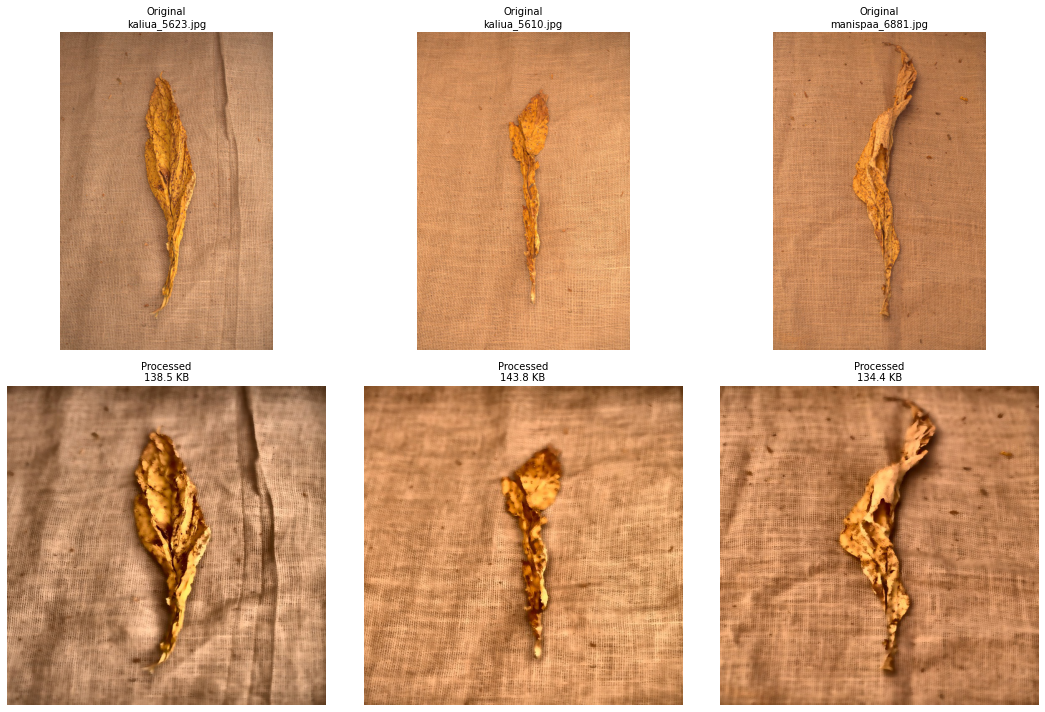

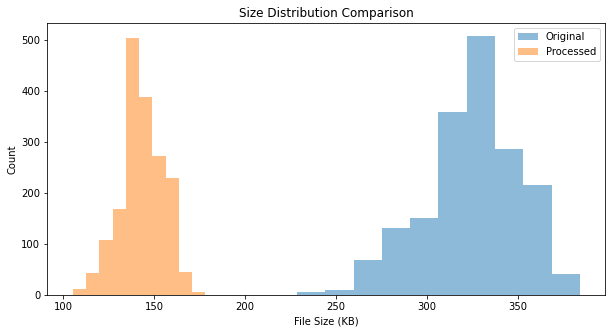

In [10]:
process_images()  # This creates processed images and metadata

In [11]:
run_feature_extraction()  # Creates full_features.parquet

,feat_0,feat_1,feat_2,feat_3,feat_4
count,1772.000000,1772.000000,1772.000000,1772.000000,1772.000000
mean,0.477272,0.000957,0.003188,0.425047,0.480842
std,0.151474,0.025326,0.035629,0.155660,0.143713
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.370364,0.000000,0.000000,0.320679,0.399043
50%,0.466588,0.000000,0.000000,0.414546,0.488365
75%,0.582407,0.000000,0.000000,0.526850,0.573006
max,1.000000,1.000000,1.000000,1.000000,1.000001


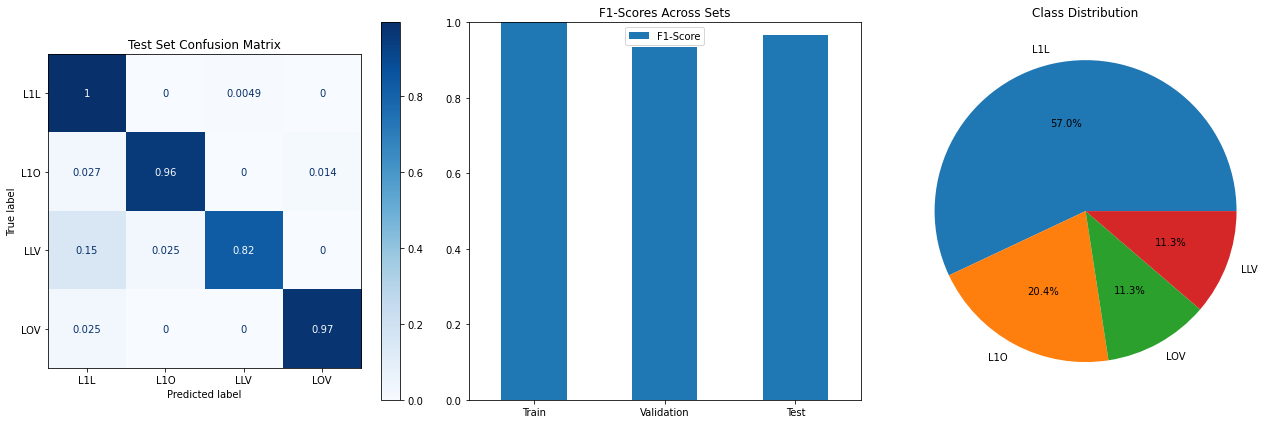

KNeighborsClassifier(metric='cosine', n_jobs=-1, n_neighbors=3,
                     weights='distance')

In [12]:
train_and_evaluate()